In [1]:
from h5py import File
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl

In [2]:
def load_attia_mat(norm='interp'):
    """
    norm: 'interp' or 'pad'
    前者透過線性插植強制讓所有cycle的長度一致; 
    後者是重複長度不夠的cycle的尾端數值, 直到滿足長度需求
    """
    assert norm in ['interp', 'pad'], 'norm must be "interp" or "pad"'
    filenames = [_ for _ in os.listdir() if _.endswith('mat')]
    print(filenames)
    first = True
    for b, f in enumerate(filenames):
        f = File(f)
        batch = f['batch']
        if first: print('batch information:', list(batch.keys()))
        for cell_id in range(len(batch['summary'])): # load summary information 
            summary = f[batch['summary'][cell_id][0]]
            if first: print('summary information:', list(summary.keys()))
            s_qd = np.array(summary['QDischarge'][0, :]).reshape(-1, 1)
            s_qc = np.array(summary['QCharge'][0, :]).reshape(-1, 1)
            # s_tavg = np.array(summary['Tavg'][0, :]).reshape(-1, 1)
            # s_tmax = np.array(summary['Tmax'][0, :]).reshape(-1, 1)
            # s_tmin = np.array(summary['Tmin'][0, :]).reshape(-1, 1)
            # s_ct = np.array(summary['chargetime'][0, :]).reshape(-1, 1)
            np.save('summary_info/b%dc%d_sum.npy'%(b+1, cell_id+1), np.concatenate([s_qd, s_qc], axis=1))

            cycles = f[batch['cycles'][cell_id][0]]
            if first: print('cycle information:', list(cycles.keys()))
            v_list = [] # voltage
            n_cycles = len(cycles['V'])
            for cycle_id in range(n_cycles):
                voltage = np.array(f[cycles['V'][cycle_id, 0]]).reshape(-1, 1)
                current = np.array(f[cycles['I'][cycle_id, 0]]).reshape(-1, 1)
                dc_interval = np.argwhere(np.diff(current<0, axis=0)!=0)
                dc_s, dc_e = dc_interval[-2, 0], dc_interval[-1, 0] # discharge start index and end index
                v_list.append(voltage[dc_s:dc_e])

            max_len = max([len(v) for v in v_list])
            for i, v in enumerate(v_list): # last padding til the length reach the longest voltage curve
                if len(v)<max_len:
                    if norm=='pad':
                        v_pad = np.full((max_len, 1), v[-1, 0])
                        v_pad[:len(v)] = v
                        v_list[i] = linear_interpolation(v_pad.flatten())
                    elif norm=='interp':
                        v_list[i] = linear_interpolation(v.flatten())
                else:
                    v_list[i] = linear_interpolation(v.flatten())
            np.save('detail_info/b%dc%d_detail.npy'%(b+1, cell_id+1), np.concatenate(v_list, axis=0))
            first = False


def linear_interpolation(seq, points=500): # interpolate the voltage curve to the 500 points
    interp_id = np.linspace(0, len(seq)-1, points)
    return np.interp(interp_id, np.arange(len(seq)), seq).reshape(1, -1, 1)

In [3]:
load_attia_mat()

['2019-01-24_batchdata_updated_struct_errorcorrect.mat']
batch information: ['Vdlin', 'barcode', 'channel_id', 'cycle_life', 'cycles', 'policy', 'policy_readable', 'summary']
summary information: ['IR', 'QCharge', 'QDischarge', 'Tavg', 'Tmax', 'Tmin', 'chargetime', 'cycle']
cycle information: ['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'discharge_dQdV', 't']


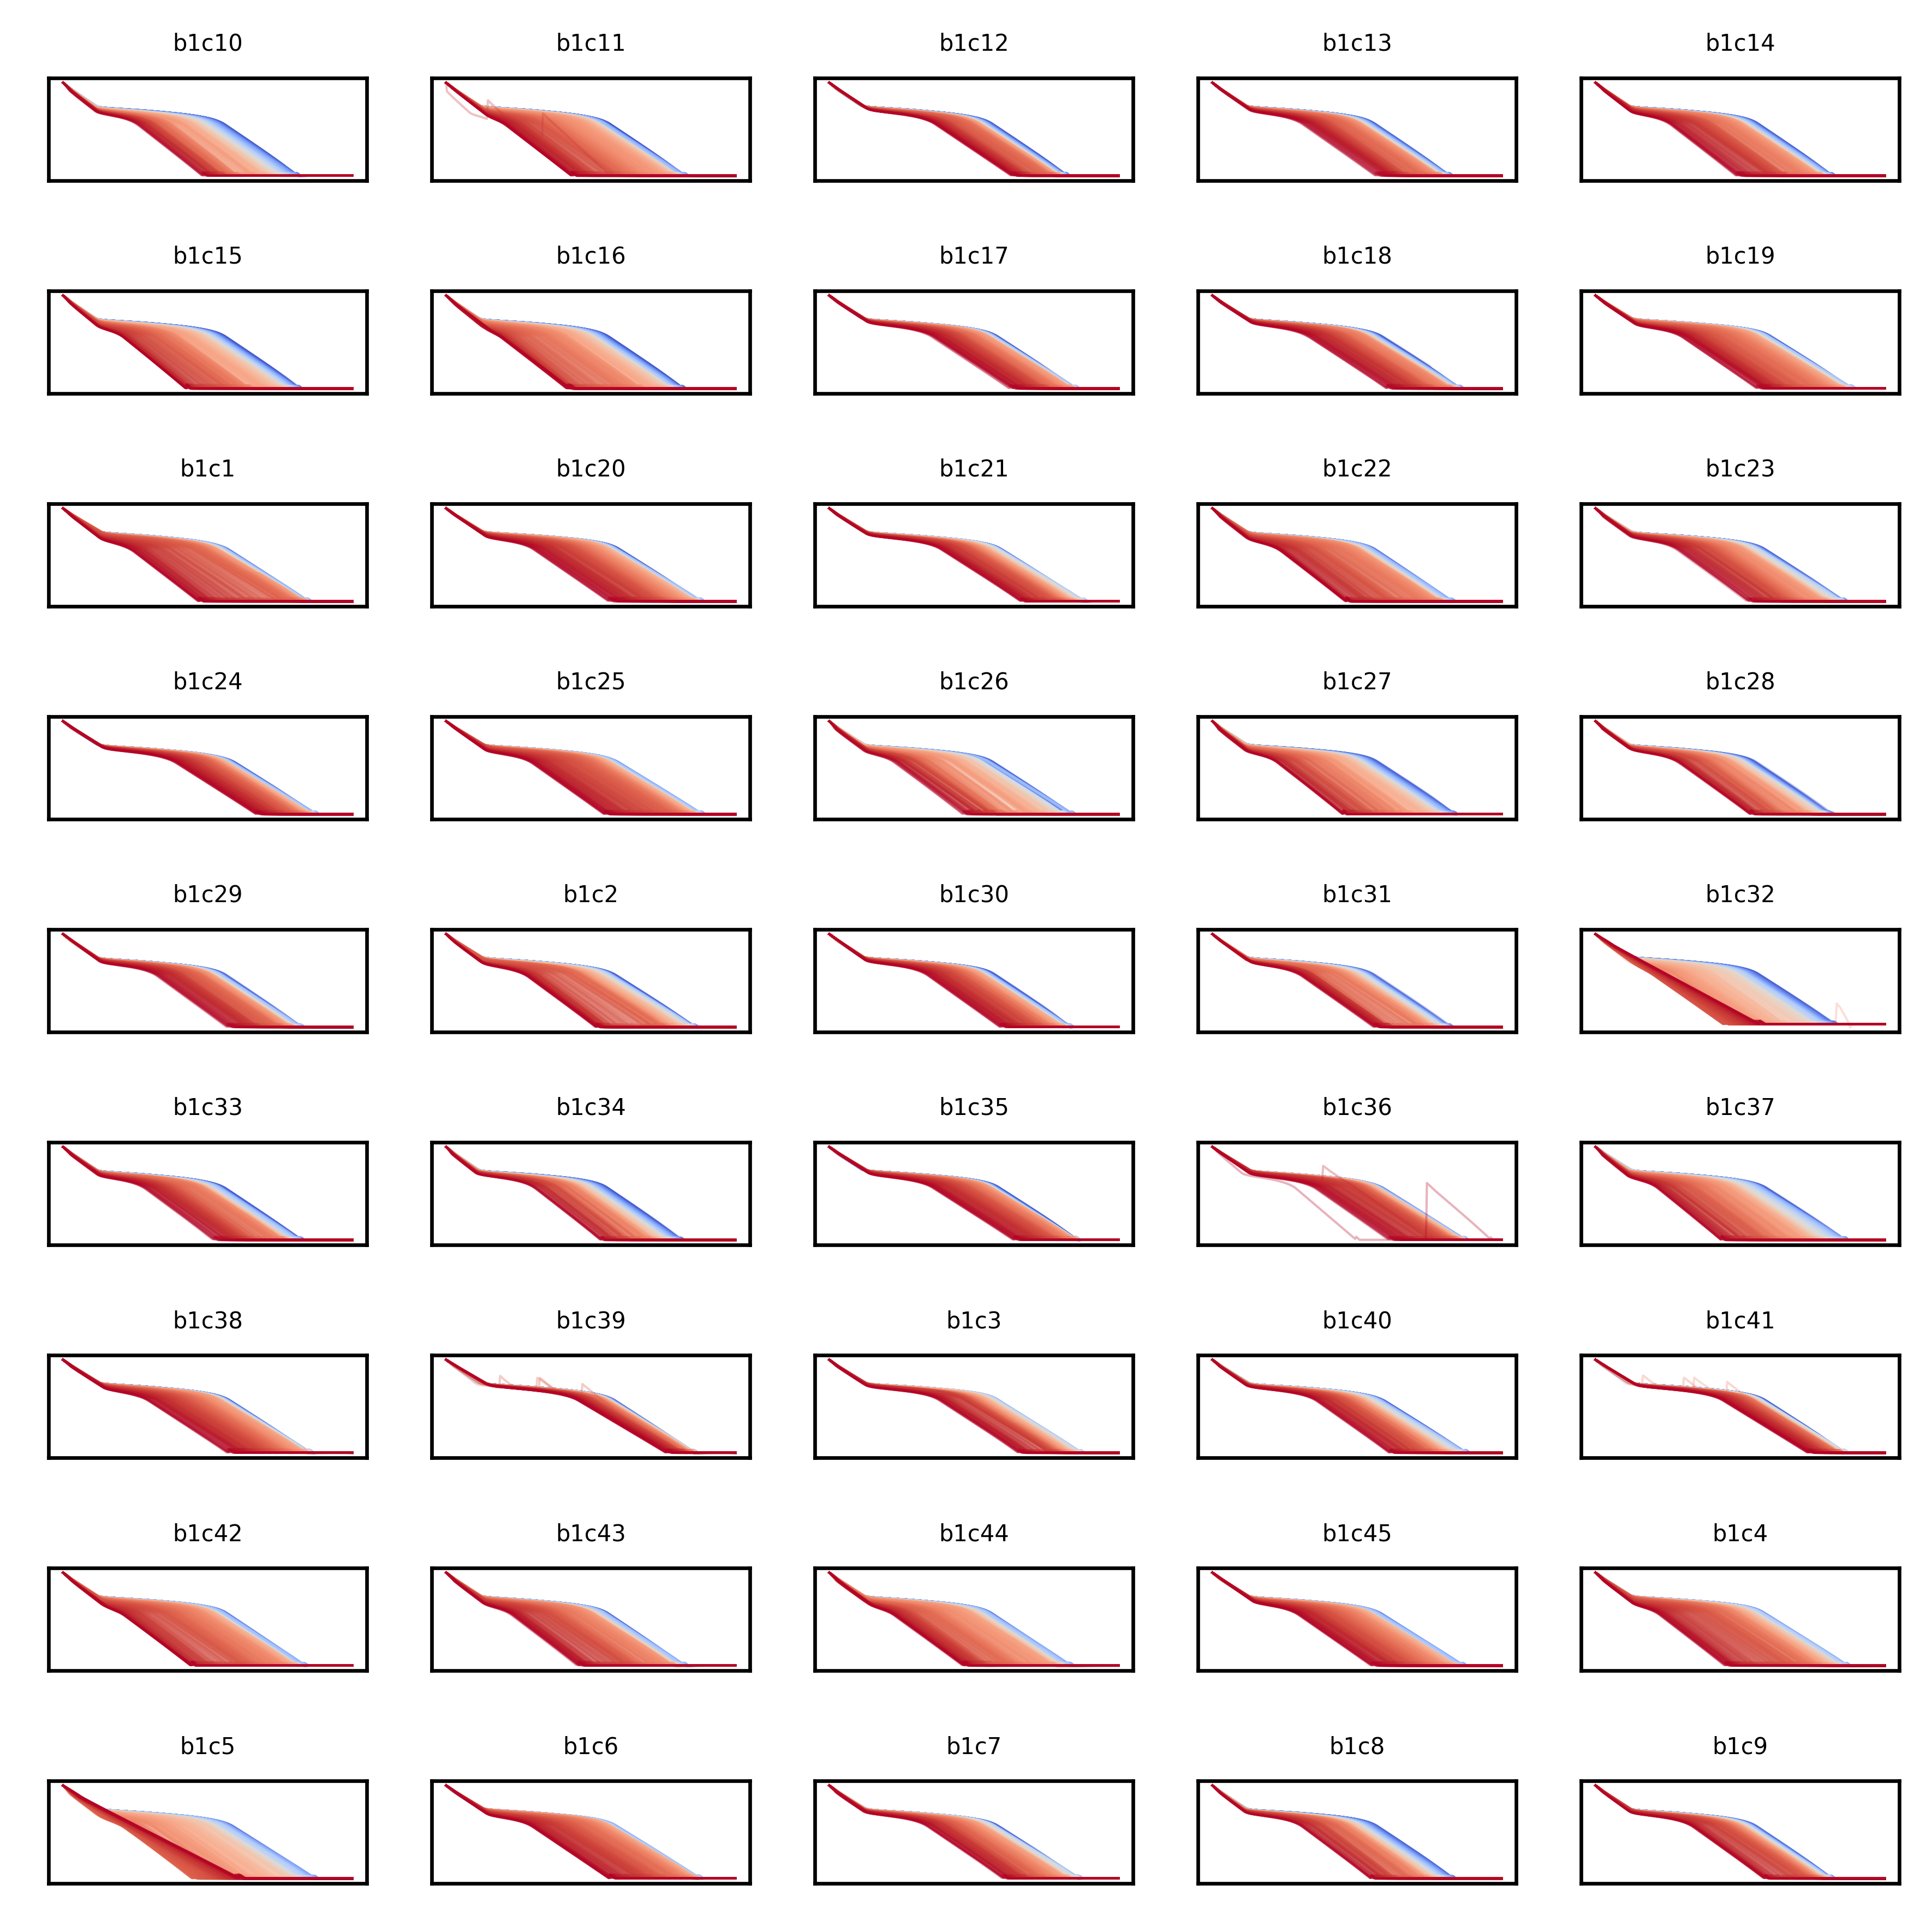

In [5]:
mpl.rcParams['figure.dpi'] = 600
def voltage_curve_plot(): # plot voltage curve of 45 cells
    filenames = [_ for _ in os.listdir('detail_info') if _.endswith('.npy')]
    cmap = plt.get_cmap('coolwarm')
    fig, ax = plt.subplots(9, 5, figsize=(6, 6))
    for i, f in enumerate(filenames):
        v = np.load('detail_info/'+f)
        for j in range(len(v)):
            ax[i//5, i%5].plot(v[j], c=cmap(j/len(v)), alpha=0.3, lw=0.5)
            ax[i//5, i%5].set_xticks([])
            ax[i//5, i%5].set_yticks([])
            ax[i//5, i%5].set_title(f[:-11], fontsize=5)
    plt.tight_layout()
    plt.show()
    plt.close()

voltage_curve_plot()